# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary


import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

c:\Users\sheri\anaconda3\anaconda_64\lib\site-packages\tensorflow\python\framework\dtypes.py:29: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from tensorflow.python.lib.core import _pywrap_bfloat16
c:\Users\sheri\anaconda3\anaconda_64\lib\site-packages\tensorflow\python\framework\dtypes.py:511: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
c:\Users\sheri\anaconda3\anaconda_64\lib\site-packages\tensorflow\python\framework\dtypes.py:553: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.

In [2]:
# add any additional libaries you need here



In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

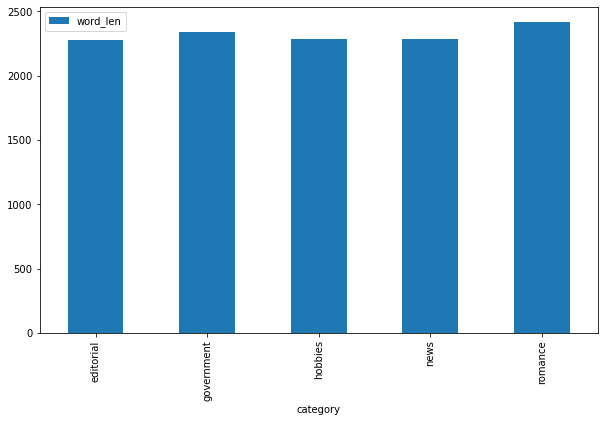

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

c:\Users\sheri\anaconda3\anaconda_64\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: `count_text_vectors` contains a matrix where the rows represent documents and columns represent unique words among all documents, the values are the number of times each word showing up in each documents. Similar for `tfidf_text_vectors` where the values shows the tfidf score for each document and each word

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

c:\Users\sheri\anaconda3\anaconda_64\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

In [18]:
# Your code here
df['topic'] = W_text_matrix.argmax(1)
pd.crosstab(df['topic'], df['category'])

category,editorial,government,hobbies,news,romance
topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Some of the topics are aligned with the correspoding category. For example, topic 2 is about tax and state development which has goverment category. Topic 0 is also mostly about editoral dicussions. Topic 1 covers most of the romance category documents, however, from the top words it is difficult to find relationsip with the category

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

In [19]:
from sklearn.decomposition import TruncatedSVD

In [23]:
# Your code here
lsa_model  = TruncatedSVD(n_components=5, n_iter=20, random_state=123)
lsa_top = lsa_model.fit_transform(tfidf_text_vectors)

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: <!-- Your answer here --> 

In [24]:
# call display_topics on your model
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.04)
  kennedy (0.81)
  laos (0.77)

Topic 03
  mrs (29.33)
  club (6.53)
  game (6.09)
  jr (5.59)
  dallas (5.27)

Topic 04
  game (4.39)
  league (3.16)
  baseball (3.13)
  ball (2.98)
  team (2.86)


In [26]:
# Your code here
df['topic'] = lsa_top.argmax(1)
pd.crosstab(df['topic'], df['category'])

category,editorial,government,hobbies,news,romance
topic,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


Q: What is your interpretation of the display topics output? 

A: From the results, it shows that the topics extracted by LSA do not have much correlation with the original category. Basically, the cross table shows that topic 0 covers all categories, and other topics do not have large enough support

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [41]:
# Fit your LDA model here
from sklearn.decomposition import LatentDirichletAllocation
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=123)
lda_top = lda_text_model.fit_transform(count_text_vectors)

In [42]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  state (0.94)
  use (0.60)
  000 (0.47)
  small (0.46)
  system (0.42)

Topic 01
  said (1.56)
  mrs (0.66)
  man (0.49)
  mr (0.45)
  old (0.43)

Topic 02
  world (0.63)
  mr (0.63)
  brown (0.60)
  west (0.57)
  khrushchev (0.55)

Topic 03
  states (0.91)
  government (0.79)
  state (0.77)
  united (0.76)
  president (0.66)

Topic 04
  feed (0.51)
  american (0.51)
  peace (0.48)
  day (0.47)
  corps (0.38)


In [43]:
df['topic'] = lda_top.argmax(1)
pd.crosstab(df['topic'], df['category'])

category,editorial,government,hobbies,news,romance
topic,,,,,
0,2,6,11,4,0
1,11,0,9,27,29
2,4,2,7,0,0
3,5,18,0,10,0
4,5,4,9,3,0


Q: What inference do you draw from the displayed topics for your LDA model? 

A: As showns in the chart, each topic is using specific set of words. Topic 3 mostly covers goverment related documents. Topic 2 mostly contains hobbies related words. 


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: LDA topics are closer to original categories, for example topic 3 covers mostly categories goverment and news

In [44]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [45]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: it shows that the 5 topics are segreggated. Topic 2 is mostly from PC1 while Topic 3 is from PC2. Also it shows that some words are very dominent in specific topis. For example, word "said" is mostly inside TOpic 2, while word "state" shows up frequently in Topic 5 and 1